# Part 1: Project Workplan

**The aim of our project is to predict churn rates* for our customer, Interconnect.**
- From our results/final report, the company will be better prepared when it comes to forecasting which clients are in a higher likelihood of disconneting their services (which more than likely is to a competitor with more enticing perks).


- Interconnect will then plan on offering a larger scope of benefits to those clients in danger of turning over. This may also prove particularly useful in its market share battle against its competitors as the telecomm industry sprints to expand their perks each year as new cell phones come out (a constant cycle).

-----

`Step 1 - Initialization`
- Import all required and prospective libraries that will be leveraged in future stages of the project.


- Download the data and briefly inspect each DataFrame structure.

`Step 2 - Preprocessing & EDA`
- Determine the necessary process to clean and massage the data.


- Create short, concise summaries on each DataFrame along with visualizations (plots) for thought organization and guidance.


- Perform EDA, including but not limited to: dtype and naming revisions, class balancing, value scaling, feature engineering, encoding and merging.
 - Fill in any gaps due to changes made to the DataFrame(s).


- Deploy time series tools/analysis to get a sense of trends and seasonality to paint a more complete picture.

`Step 3 - Model Selection, Training and Fine-Tuning`
- Select various models based on the goal, binary classification. Compare initial scoring performance across the model selections, incorporate a dummy model benchmark.


- Fine-tune models using hyperparameters and gridsearches. Include gradient boosting techniques. 

`Step 4 - Model Evaluation`
- Decide on the optimal model based on cross comparisons and boosting techniques. Perform model evaluation based on a new set of data (test dataset) and document results. 


- If statisfactory, record why the model was selected, its results (along with speed and accuracy insights) and what needs to be done in order to monitor/manage the model in a go-forward basis.

`Step 5 - Comprehensive Report`
- Create an extensive report on the process/steps taken, the results and the overall recommendations.
 - Illustrate findings/results incorporating 'quick hits' or 'highlights' so the customer has a better handle on the report and can easily share internally.




--------

**The churn rate measures a company's loss in subscribers for a given period of time. The cost of acquiring new customers is much higher than it is to retain current customers.*

-----------

# Part 2: Solution Code

# Initialization

In [184]:
def warn(*args, **kwargs): # attempt at removing warnings
    pass
import warnings
warnings.warn = warn

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [185]:
# common libraries
import pandas as pd
import numpy as np
from functools import reduce
from numpy import unique

# other libraries
# from scipy.stats import randint as 

# viz libraries
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
px.defaults.template = "plotly_white"
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, iplot, plot
init_notebook_mode(connected=True)
# import pygwalker as pyg # leveraging once DFs are merged

# sklearn
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, accuracy_score, ConfusionMatrixDisplay, auc, roc_curve
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.utils import shuffle, resample
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold

# gradient boosting
import lightgbm as lgb
import xgboost as xgb

In [186]:
try:
    contract_data = pd.read_csv('/kaggle/input/final-provider/contract.csv') # index_col=[0], parse_dates=[0]
    personal_data = pd.read_csv('/kaggle/input/final-provider/personal.csv') 
    internet_data = pd.read_csv('/kaggle/input/final-provider/internet.csv') 
    phone_data = pd.read_csv('/kaggle/input/final-provider/phone.csv') 
except:
    contract_data = pd.read_csv('/Users/dani/Data Science/TripleTen Projects/Project Data/Final Project/contract.csv') # index_col=[0], parse_dates=[0]
    personal_data = pd.read_csv('/Users/dani/Data Science/TripleTen Projects/Project Data/Final Project/personal.csv') 
    internet_data = pd.read_csv('/Users/dani/Data Science/TripleTen Projects/Project Data/Final Project/internet.csv') 
    phone_data = pd.read_csv('/Users/dani/Data Science/TripleTen Projects/Project Data/Final Project/phone.csv') 

-----------

# Exploratory Data Analysis

In [187]:
encoder = LabelEncoder() 

In [188]:
# to bypass limitations and encode multiple columns
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # column names to encode

    def fit(self,X,y=None):
        return self 

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [189]:
# function to classify features
def classify_features(df):
    categorical_features = []
    non_categorical_features = []
    discrete_features = []
    continuous_features = []

    for column in df.columns:
        if df[column].dtype in ['object', 'bool', 'category']: 
            if df[column].nunique() < 15:
                categorical_features.append(column)
            else: 
                non_categorical_features.append(column)
        elif df[column].dtype in ['int64', 'float64']:
            if df[column].nunique() < 10:
                discrete_features.append(column)
            else: 
                continuous_features.append(column)
    return categorical_features, non_categorical_features, discrete_features, continuous_features

-----------

# Contract data

In [190]:
contract_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [191]:
categorical, non_categorical, discrete, continuous = classify_features(contract_data)

print("Categorical Features:", categorical)
print("Non-Categorical Features:", non_categorical)
print("Discrete Features:", discrete)
print("Continuous Features:", continuous)

Categorical Features: ['EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod']
Non-Categorical Features: ['customerID', 'BeginDate', 'TotalCharges']
Discrete Features: []
Continuous Features: ['MonthlyCharges']


In [192]:
contract_data.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [193]:
contract_data.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [194]:
display(contract_data)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


`Preprocessing`

In [195]:
contract_df = contract_data.copy()
# column renaming
contract_df = contract_df.rename(columns={"customerID": "customer_id", "BeginDate": "begin_date", "EndDate": "end_date", "Type": "contract_type",
                           "PaperlessBilling": "paperless_billing", "PaymentMethod": "payment_method", "MonthlyCharges": "monthly_charges",
                           "TotalCharges": "total_charges"})

# datatype conversions
contract_df['begin_date'] = pd.to_datetime(contract_df['begin_date'])


# display(contract_df.iloc[488]) # first error callout, turns out there are 11 rows without a 'total_charges' value
# display(contract_df['total_charges'].isnull().sum()) 
problem_cells = [ ]

for value in contract_df['total_charges']:
    try:
        pd.to_numeric(value)
    except:
        problem_cells.append(value)
        
display(problem_cells)
display()

contract_df['total_charges'].replace(" ", np.nan, inplace=True) # replacing empty strings so we can drop the rows
contract_df['total_charges'] = pd.to_numeric(contract_df['total_charges']) # conversion to match 'monthly_charges'
contract_df = contract_df.dropna(subset=['total_charges']) # 11 rows should not make that big of a dent given it's a tiny percentage of total

contract_df.info()

[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   object        
 3   contract_type      7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 494.4+ KB


In [196]:
# target handling
contract_df.query('end_date == " "') # no empty cells in target column

contract_df['churn_target'] = np.where(contract_df['end_date'] == 'No', 1, 0) # 1 = no churn, 0 = churn
contract_df = contract_df.drop(['end_date'], axis=1)

display(contract_df)

,customer_id,begin_date,contract_type,paperless_billing,payment_method,monthly_charges,total_charges,churn_target
0,7590-VHVEG,2020-01-01,Month-to-month,Yes,Electronic check,29.85,29.85,1
1,5575-GNVDE,2017-04-01,One year,No,Mailed check,56.95,1889.50,1
2,3668-QPYBK,2019-10-01,Month-to-month,Yes,Mailed check,53.85,108.15,0
3,7795-CFOCW,2016-05-01,One year,No,Bank transfer (automatic),42.30,1840.75,1
4,9237-HQITU,2019-09-01,Month-to-month,Yes,Electronic check,70.70,151.65,0
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,One year,Yes,Mailed check,84.80,1990.50,1
7039,2234-XADUH,2014-02-01,One year,Yes,Credit card (automatic),103.20,7362.90,1
7040,4801-JZAZL,2019-03-01,Month-to-month,Yes,Electronic check,29.60,346.45,1
7041,8361-LTMKD,2019-07-01,Month-to-month,Yes,Mailed check,74.40,306.60,0


In [197]:
payment_grp = contract_df.groupby(['contract_type','payment_method']).size().reset_index().groupby('payment_method')[[0]].max()
# display(payment_grp)
fig = px.bar(payment_grp,title="Customer Payment Method",text_auto = True)
fig.update_layout(showlegend=False)
fig.show()

contract_type_grp = contract_df.groupby(['contract_type','payment_method']).size().reset_index().groupby('contract_type')[[0]].max()
# display(contract_type_grp)
fig = px.bar(contract_type_grp,title="Customer Contract Type",text_auto = True)
fig.update_layout(showlegend=False)
fig.show()

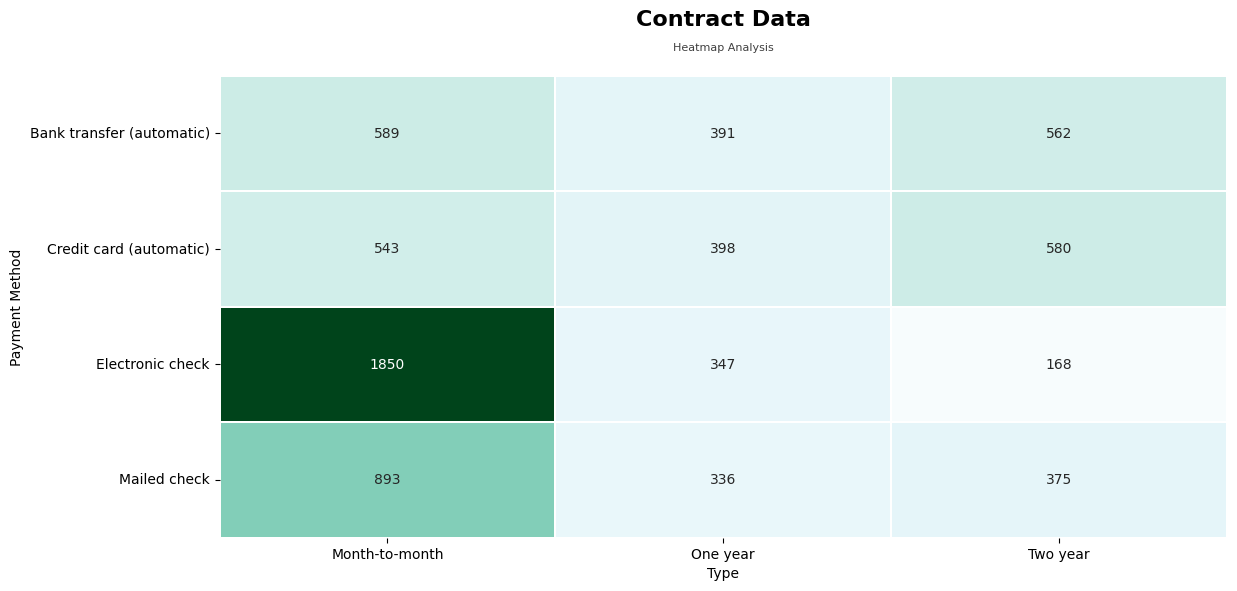

In [198]:
crosstab = pd.crosstab(contract_df['payment_method'], contract_df['contract_type'])
fig, ax = plt.subplots(figsize=(13, 6))
g = sns.heatmap(crosstab, cbar=False, cmap="BuGn", linewidths=0.3, annot=True, fmt='d', ax=ax)

g.set_ylabel('Payment Method')
g.set_xlabel('Type')

ax.text(x=0.5, y=1.1, s='Contract Data', fontsize=16, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.05, s='Heatmap Analysis', fontsize=8, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)

plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.show()

In [199]:
# label encoding
contract_df = MultiColumnLabelEncoder(columns = ['contract_type','paperless_billing', 'payment_method']).fit_transform(contract_df)

display(contract_df)

,customer_id,begin_date,contract_type,paperless_billing,payment_method,monthly_charges,total_charges,churn_target
0,7590-VHVEG,2020-01-01,0,1,2,29.85,29.85,1
1,5575-GNVDE,2017-04-01,1,0,3,56.95,1889.50,1
2,3668-QPYBK,2019-10-01,0,1,3,53.85,108.15,0
3,7795-CFOCW,2016-05-01,1,0,0,42.30,1840.75,1
4,9237-HQITU,2019-09-01,0,1,2,70.70,151.65,0
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,1,1,3,84.80,1990.50,1
7039,2234-XADUH,2014-02-01,1,1,1,103.20,7362.90,1
7040,4801-JZAZL,2019-03-01,0,1,2,29.60,346.45,1
7041,8361-LTMKD,2019-07-01,0,1,3,74.40,306.60,0


`Summary`

Peaking into our contract data, we see issues with column naming, and column datatypes. We attempt amend those two to start and find that one of the features has empty strings in it's value range (through an iterative examination). 

Once we find the specific culprits, we replace with NaN values so we can then drop the rows themselves. Thse are small in numbers compared to the entire DF and so are more comfortable with the removal and do not expect much, if any, impact down the line. 

-----------

# Personal data

In [200]:
personal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [201]:
categorical, non_categorical, discrete, continuous = classify_features(personal_data)

print("Categorical Features:", categorical)
print("Non-Categorical Features:", non_categorical)
print("Discrete Features:", discrete)
print("Continuous Features:", continuous)

Categorical Features: ['gender', 'Partner', 'Dependents']
Non-Categorical Features: ['customerID']
Discrete Features: ['SeniorCitizen']
Continuous Features: []


In [202]:
for i in categorical:
    #print(i, ':')
    print(personal_data[i].value_counts())
    fig = px.bar(personal_data[i].value_counts(), labels={'value':'Count (#)'}, text_auto=True).update_layout(showlegend=False).update_traces(marker_color='darkgreen')
    print()
    fig.show()
    fig.show()

gender
Male      3555
Female    3488
Name: count, dtype: int64



Partner
No     3641
Yes    3402
Name: count, dtype: int64



Dependents
No     4933
Yes    2110
Name: count, dtype: int64



In [203]:
personal_data.describe()

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [204]:
personal_data.isna().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

In [205]:
display(personal_data)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


`Preprocessing`

In [206]:
personal_df = personal_data.copy()
# column renaming
personal_df = personal_df.rename(columns={"customerID": "customer_id", "SeniorCitizen": "senior_citizen",
                                          "Partner": "partner", "Dependents": "dependents"})

In [207]:
personal_grp = personal_df.groupby(['partner','gender']).size().reset_index().groupby('gender')[[0]].max()

labels = ['Male', 'Female']
fig = px.pie(personal_grp, names=labels, title='Gender Mix')
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))

fig.show()

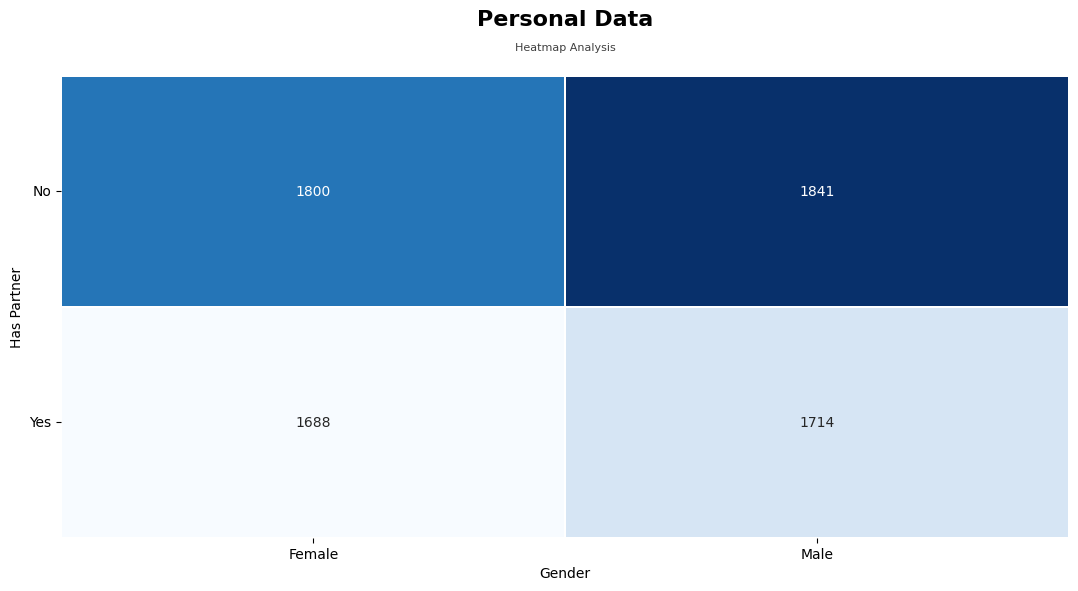

In [208]:
crosstab = pd.crosstab(personal_df['partner'], personal_df['gender'])
fig, ax = plt.subplots(figsize=(13, 6))
g = sns.heatmap(crosstab, cbar=False, cmap="Blues", linewidths=0.3, annot=True, fmt='d', ax=ax)

g.set_ylabel('Has Partner')
g.set_xlabel('Gender')

ax.text(x=0.5, y=1.1, s='Personal Data', fontsize=16, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.05, s='Heatmap Analysis', fontsize=8, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)

plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.show()

In [209]:
# label encoding
personal_df = MultiColumnLabelEncoder(columns = ['gender','senior_citizen', 'partner', 'dependents']).fit_transform(personal_df)

display(personal_df)

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,0,0,1,0
1,5575-GNVDE,1,0,0,0
2,3668-QPYBK,1,0,0,0
3,7795-CFOCW,1,0,0,0
4,9237-HQITU,0,0,0,0
...,...,...,...,...,...
7038,6840-RESVB,1,0,1,1
7039,2234-XADUH,0,0,1,1
7040,4801-JZAZL,0,0,1,1
7041,8361-LTMKD,1,1,1,0


`Summary`

Similar instances of column revisions for personal_data but we preemtively being feature encoding through a function that handles multiple column encoding. These values then become inputs the eventual models can handle and make sense of.

-----------

# Internet data

In [210]:
internet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [211]:
categorical, non_categorical, discrete, continuous = classify_features(internet_data)

print("Categorical Features:", categorical)
print("Non-Categorical Features:", non_categorical)
print("Discrete Features:", discrete)
print("Continuous Features:", continuous)

Categorical Features: ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
Non-Categorical Features: ['customerID']
Discrete Features: []
Continuous Features: []


In [212]:
for i in categorical:
    #print(i, ':')
    print(internet_data[i].value_counts())
    fig = px.bar(internet_data[i].value_counts(), labels={'value':'Count (#)'}, text_auto=True).update_layout(showlegend=False).update_traces(marker_color='darkblue')
    print()
    fig.show()
    fig.show()

InternetService
Fiber optic    3096
DSL            2421
Name: count, dtype: int64



OnlineSecurity
No     3498
Yes    2019
Name: count, dtype: int64



OnlineBackup
No     3088
Yes    2429
Name: count, dtype: int64



DeviceProtection
No     3095
Yes    2422
Name: count, dtype: int64



TechSupport
No     3473
Yes    2044
Name: count, dtype: int64



StreamingTV
No     2810
Yes    2707
Name: count, dtype: int64



StreamingMovies
No     2785
Yes    2732
Name: count, dtype: int64



In [213]:
internet_data.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [214]:
internet_data.isna().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [215]:
display(internet_data)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


`Preprocessing`

In [216]:
internet_df = internet_data.copy()
# column renaming
internet_df = internet_df.rename(columns={"customerID": "customer_id", "InternetService": "internet_service", "OnlineSecurity": "online_security", "OnlineBackup": "online_backup",
                                         "DeviceProtection": "device_protection", "TechSupport": "tech_support", "StreamingTV": "streaming_tv",
                                         "StreamingMovies": "streaming_movies"})

display(internet_df)

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [217]:
internet_grp = internet_df.groupby(['online_security','internet_service']).size().reset_index().groupby('internet_service')[[0]].max()

fig = px.bar(internet_grp, title="Customer Internet Service Type",text_auto = True)
fig.update_layout(showlegend=False)
fig.show()

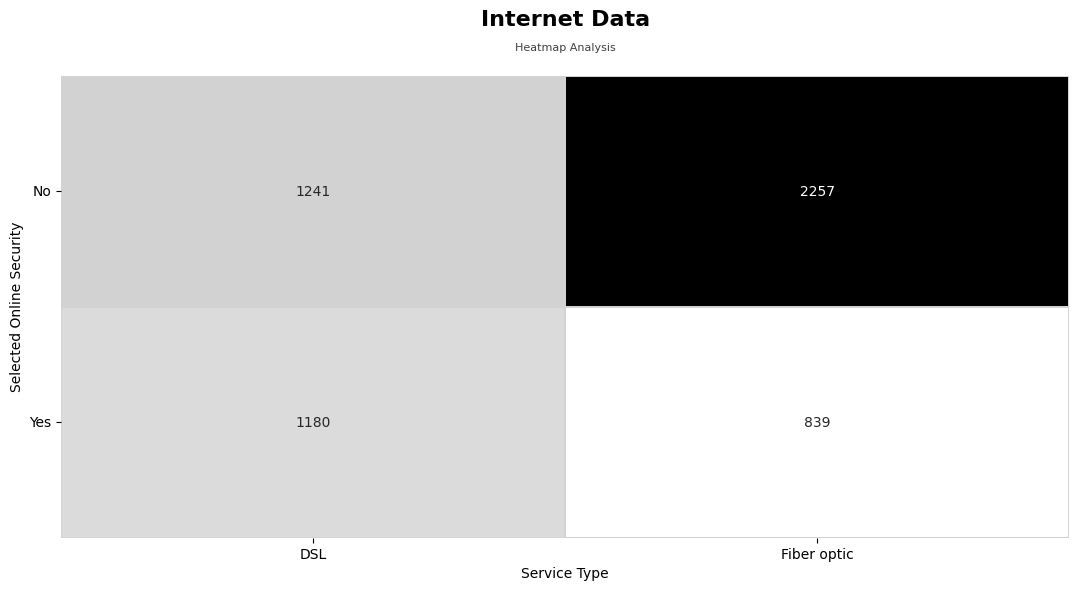

In [218]:
crosstab = pd.crosstab(internet_df['online_security'], internet_df['internet_service'])
fig, ax = plt.subplots(figsize=(13, 6))
g = sns.heatmap(crosstab, cbar=False, cmap="Grays", linewidths=0.0029, annot=True, fmt='d', linecolor='lightgray', ax=ax)

g.set_ylabel('Selected Online Security')
g.set_xlabel('Service Type')

ax.text(x=0.5, y=1.1, s='Internet Data', fontsize=16, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.05, s='Heatmap Analysis', fontsize=8, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)

plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.show()

In [219]:
# label encoding
internet_df = MultiColumnLabelEncoder(columns = ['internet_service','online_security', 'online_backup', 'device_protection','tech_support', 'streaming_tv', 'streaming_movies']).fit_transform(internet_df)

display(internet_df)

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,0,0,1,0,0,0,0
1,5575-GNVDE,0,1,0,1,0,0,0
2,3668-QPYBK,0,1,1,0,0,0,0
3,7795-CFOCW,0,1,0,1,1,0,0
4,9237-HQITU,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,0,1,0,1,1,1,1
5513,2234-XADUH,1,0,1,1,0,1,1
5514,4801-JZAZL,0,1,0,0,0,0,0
5515,8361-LTMKD,1,0,0,0,0,0,0


`Summary`

Looking into our internet_data, we see a smaller number of rows and therefore have a smaller number of customer_ids (compared to all the other sets). 

We perform some renaming and label encoding to the columns. After doing so, we are making the assumption that those customer_ids that are not included in this dataset did not sign up for the internet services therefore we will also make the assumption that where we find NaNs in our final, merged set we can replace those with 'No' or 'Not subscribed'.

-----------

# Phone data

In [220]:
phone_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [221]:
categorical, non_categorical, discrete, continuous = classify_features(phone_data)

print("Categorical Features:", categorical)
print("Non-Categorical Features:", non_categorical)
print("Discrete Features:", discrete)
print("Continuous Features:", continuous)

Categorical Features: ['MultipleLines']
Non-Categorical Features: ['customerID']
Discrete Features: []
Continuous Features: []


In [222]:
phone_data.describe()

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


In [223]:
phone_data.isna().sum()

customerID       0
MultipleLines    0
dtype: int64

In [224]:
display(phone_data)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


`Preprocessing`

In [225]:
phone_df = phone_data.copy()
# column renaming
phone_df = phone_df.rename(columns={"customerID": "customer_id", "MultipleLines": "multiple_lines"})

display(phone_df)

,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


In [226]:
# label encoding
phone_df.multiple_lines = encoder.fit_transform(phone_df.multiple_lines.values)
display(phone_df)

,customer_id,multiple_lines
0,5575-GNVDE,0
1,3668-QPYBK,0
2,9237-HQITU,0
3,9305-CDSKC,1
4,1452-KIOVK,1
...,...,...
6356,2569-WGERO,0
6357,6840-RESVB,1
6358,2234-XADUH,1
6359,8361-LTMKD,1


`Summary`

Our last DF in question, phone_data, has a smaller subset of data and one feature we are insterested in called 'multiple_lines'. We fix the column naming convention to mirror the edits we made to the other DFs and we encode our selected feature using label encoding. 

-----------

# Merging

In [227]:
# merge data based off of customer_id, main DF should be contract_df
# contract, personal, phone merge to start
# null values from phone_df will need to be monitored with options to 1) remove (if small impact), 2) replace (average,std) or, 3) keep in place

# merged_df = contract_df.merge(personal_df,
#                              on='customer_id',
#                              ).merge(phone_df, on='customer_id', how='left')

# display(merged_df)

# display(merged_df.query('multiple_lines.isna()')) # attempting to find commonality for NaN values under 'multiple_lines' -- nothing in common 

data_frames = [contract_df, personal_df, internet_df, phone_df]

merged_df = reduce(lambda  left, right: pd.merge(left, right, on=['customer_id'],
                                            how='left'), data_frames)

display(merged_df) # should include most of our 'customer_id' instances

,customer_id,begin_date,contract_type,paperless_billing,payment_method,monthly_charges,total_charges,churn_target,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,0,1,2,29.85,29.85,1,0,0,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN
1,5575-GNVDE,2017-04-01,1,0,3,56.95,1889.50,1,1,0,0,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3668-QPYBK,2019-10-01,0,1,3,53.85,108.15,0,1,0,0,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,7795-CFOCW,2016-05-01,1,0,0,42.30,1840.75,1,1,0,0,0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,NaN
4,9237-HQITU,2019-09-01,0,1,2,70.70,151.65,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,6840-RESVB,2018-02-01,1,1,3,84.80,1990.50,1,1,0,1,1,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
7028,2234-XADUH,2014-02-01,1,1,1,103.20,7362.90,1,0,0,1,1,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
7029,4801-JZAZL,2019-03-01,0,1,2,29.60,346.45,1,0,0,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN
7030,8361-LTMKD,2019-07-01,0,1,3,74.40,306.60,0,1,1,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [228]:
# dropping columns that don't impact analysis 
merged_df = merged_df.drop('customer_id', axis=1)

In [229]:
# dropping rows with NaNs under 'multiple_lines' as a test, reverting back to this and filling in if there are score issues with models
# lines_filter = merged_df.query('multiple_lines.isna()')
# merged_df.drop(merged_df[merged_df['multiple_lines'].isna()].index, inplace=True)

# dropping rows with NaNs under 'internet_service' as a test, reverting back to this and filling in if there are score issues with models
# service_filter = merged_df.query('internet_service.isna()') #1520 rows with NaNs, removal might be required 

# we are making the assumption that NaN under multiple_lines == No and NaN under the internet_df means they did not sign up, so == No as well
merged_df = merged_df.fillna(0)

display(merged_df)

,begin_date,contract_type,paperless_billing,payment_method,monthly_charges,total_charges,churn_target,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,2020-01-01,0,1,2,29.85,29.85,1,0,0,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2017-04-01,1,0,3,56.95,1889.50,1,1,0,0,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2019-10-01,0,1,3,53.85,108.15,0,1,0,0,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2016-05-01,1,0,0,42.30,1840.75,1,1,0,0,0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
4,2019-09-01,0,1,2,70.70,151.65,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,2018-02-01,1,1,3,84.80,1990.50,1,1,0,1,1,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
7028,2014-02-01,1,1,1,103.20,7362.90,1,0,0,1,1,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
7029,2019-03-01,0,1,2,29.60,346.45,1,0,0,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7030,2019-07-01,0,1,3,74.40,306.60,0,1,1,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


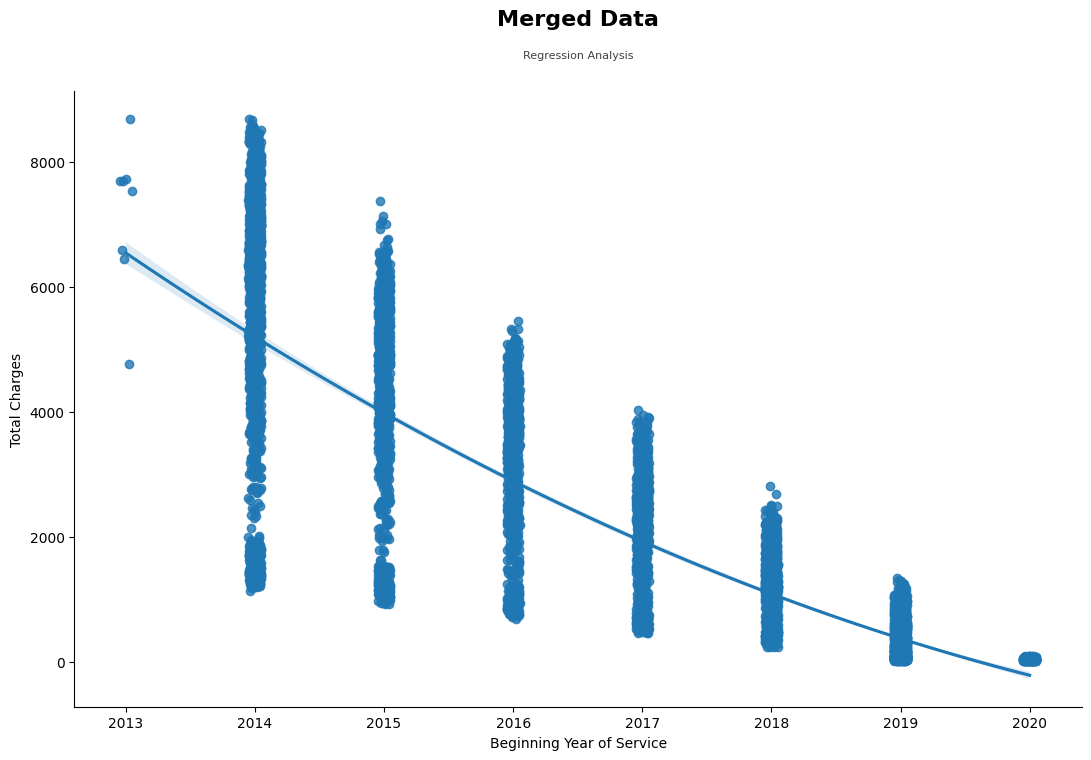

In [230]:
fig, ax = plt.subplots(figsize=(13, 8))
g = sns.regplot(data=merged_df, x=merged_df['begin_date'].dt.year,y='total_charges', order=2,
                x_jitter=.05
                #x_estimator=np.mean
                )

g.set_ylabel('Total Charges')
g.set_xlabel('Beginning Year of Service')

sns.despine()

ax.text(x=0.5, y=1.1, s='Merged Data', fontsize=16, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.05, s='Regression Analysis', fontsize=8, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)

plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.show()
plt.show()

`Summary`

We merged all but one of our DFs in our project with our 'contract_data' being the lead DF given the substantial information included. 
We decide to keep all the matches on the DFs which, knowingly, gives us some NaNs based off of our 'phone_data' -- we keep in our merged DF for now to see how our models react to seeing such values. 

If issues arise, we will revisit this section and run through a few options for our NaNs. This includes removing the rows or replacing them.

-----------

# Target Frequency

In [155]:
class_frequency = merged_df['churn_target'].value_counts()
print('Checking frequency:')
print(class_frequency)

#class_frequency.plot.pie(autopct='%.2f',textprops={'fontsize':12}, colors=['cyan', 'teal']) # calls for upsampling 'rare' or churn target values (26.58%)

labels = ['No Churn', 'Churn']
fig = px.pie(class_frequency, values='count', names=labels, title='Class Frequency')
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))

fig.show()

Checking frequency:
churn_target
1    5163
0    1869
Name: count, dtype: int64


-----------

# Model Preparation

`Fixed Parameter`

In [156]:
# random_state parameter for all models
random_state = 12345

`CV`

Rearranging the data so as to ensure that each fold is a good representative of the whole

In [157]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=random_state)

`Feature Engineering`

In [158]:
# extracting date features from datetime column
def make_features(data, col):
    data['begin_year'] = data[col].dt.year
    data['begin_month'] = data[col].dt.month
    # data['begin_day'] = data[col].dt.day # no impact to model outputs
    data['begin_dayofweek'] = data[col].dt.dayofweek
    
#     for lag in range(1, max_lag + 1):
#         data['lag_{}'.format(lag)] = data['PJME_MW'].shift(lag)

#     data['rolling_mean'] = data['PJME_MW'].shift().rolling(rolling_mean_size).mean()
#     #data['rolling_mean'] = data['PJME_MW'].rolling(rolling_mean_size).mean()

make_features(merged_df, 'begin_date')
merged_df = merged_df.drop('begin_date', axis = 1) # removing as this has been replaced by the newly created features

display(merged_df)

,contract_type,paperless_billing,payment_method,monthly_charges,total_charges,churn_target,gender,senior_citizen,partner,dependents,...,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,begin_year,begin_month,begin_dayofweek
0,0,1,2,29.85,29.85,1,0,0,1,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020,1,2
1,1,0,3,56.95,1889.50,1,1,0,0,0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2017,4,5
2,0,1,3,53.85,108.15,0,1,0,0,0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2019,10,1
3,1,0,0,42.30,1840.75,1,1,0,0,0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,2016,5,6
4,0,1,2,70.70,151.65,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,1,1,3,84.80,1990.50,1,1,0,1,1,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,2018,2,3
7028,1,1,1,103.20,7362.90,1,0,0,1,1,...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,2014,2,5
7029,0,1,2,29.60,346.45,1,0,0,1,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2019,3,4
7030,0,1,3,74.40,306.60,0,1,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2019,7,0


`Features and Target`

In [159]:
features = merged_df.drop('churn_target', axis=1)
target = merged_df['churn_target']

`Data Splitting`

In [160]:
# splitting the data into a training, validation and test dataset
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.2, random_state=12345, stratify=target)

features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train, 
                                                                          test_size=0.25, random_state=12345, stratify=target_train)

print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(features_test.shape)

(4218, 20)
(4218,)
(1407, 20)
(1407, 20)


In [161]:
# target_train summary
classes = unique(target_train)
total = len(target_train)
for c in classes:
    n_examples = len(target_train[target_train==c])
    percent = n_examples / total * 100
    print('> Class = %d : %d/%d (%.1f%%)' % (c, n_examples, total, percent))

> Class = 0 : 1121/4218 (26.6%)
> Class = 1 : 3097/4218 (73.4%)


In [162]:
# summarize by set
train_0, train_1 = len(target_train[target_train==0]), len(target_train[target_train==1])
valid_0, valid_1 = len(target_valid[target_valid==0]), len(target_valid[target_valid==1])
test_0, test_1 = len(target_test[target_test==0]), len(target_test[target_test==1])
print('Train: 0=%d, 1=%d, \nValid: 0=%d, 1=%d, \nTest: 0=%d, 1=%d' % (train_0, train_1, valid_0, valid_1 , test_0, test_1))

Train: 0=1121, 1=3097, 
Valid: 0=374, 1=1033, 
Test: 0=374, 1=1033


`Scaling`

In [163]:
numeric = ['monthly_charges', 'total_charges', 'begin_year','begin_month', 'begin_dayofweek']

def scaling(x_train, x_valid, x_test):
    scaler = MinMaxScaler()
    scaler.fit(x_train[numeric])
    x_train[numeric] = scaler.transform(x_train[numeric])
    x_valid[numeric] = scaler.transform(x_valid[numeric])
    x_test[numeric] = scaler.transform(x_test[numeric])
    return x_train, x_valid, x_test

scaling(features_train, features_valid, features_test)

(      contract_type  paperless_billing  payment_method  monthly_charges  \
 95                0                  1               2         0.604582   
 4644              1                  1               1         0.013944   
 5562              1                  1               2         0.613048   
 320               1                  0               0         0.639442   
 303               2                  0               1         0.418825   
 ...             ...                ...             ...              ...   
 5421              0                  1               1         0.536853   
 5945              0                  1               1         0.366036   
 945               0                  1               2         0.804781   
 6246              1                  1               3         0.919323   
 6745              0                  1               0         0.712151   
 
       total_charges  gender  senior_citizen  partner  dependents  \
 95         0.104

`Summary`

After taking into account class imbalancing, we've split the data into Train, Validation and Test datasets where each has been scaled in order to take value magnitute into account and create good inputs for our model training.

# Dummy Model

In [164]:
dummy = DummyClassifier(random_state=random_state,strategy="most_frequent")
dummy.fit(features_train, target_train)
DummyClassifier(strategy='most_frequent')
dummy.predict(features_valid)
print('Dummy Model Score:', dummy.score(features_valid, target_valid))

Dummy Model Score: 0.7341862117981521


# Random Forest

In [165]:
%%time
forest_model = RandomForestClassifier(random_state=random_state)
forest_parameters = [{'max_depth': [2,6,12,18,30],
                     'min_samples_split': [2,6,12],
                     "criterion": ['gini', 'entropy', 'log_loss'],
                     "warm_start": [True, False],
                     'n_estimators': [50,100,200]}]

forest_clf = RandomizedSearchCV(forest_model, forest_parameters, scoring='roc_auc', n_jobs=-1, cv=cv)
forest_clf.fit(features_train, target_train)
# create a variable for the best model
best_for = forest_clf.best_estimator_
for_pred = best_for.predict(features_valid)
print('Runtime:')

KeyboardInterrupt: 

In [ ]:
forest_scores = cross_val_score(forest_model, features_train, target_train, cv=cv, scoring='roc_auc')
print('Cross Validation Scores: {}'.format(forest_scores))

Cross Validation Scores: [0.88701779 0.86640265 0.88940092 0.84344758 0.87862903 0.87919067
 0.86424251 0.84251152 0.89613673 0.88196371 0.83515193 0.86029666
 0.89203629 0.87079493 0.88859447 0.87049251 0.89919355 0.86601382
 0.90471856 0.87202381 0.84351462 0.896803   0.8889977  0.8749424
 0.87351671 0.90600518 0.88781682 0.88974654 0.87455213 0.83183079
 0.87531861 0.85427707 0.87151498 0.89668779 0.89811348 0.8905962
 0.865625   0.865553   0.87138812 0.87749942 0.87534725 0.88326613
 0.85733007 0.84854551 0.87587846 0.8812212  0.88701037 0.90756048
 0.8802589  0.884911  ]


In [ ]:
# summary
print('Best hyperparameters:',  forest_clf.best_params_)
print()
print('Best score:', forest_clf.best_score_)
print()
print('Average Cross Validation Score: {}'.format(forest_scores.mean()))
print()
print('ROC AUC Score - Validation Dataset:',  roc_auc_score(target_valid, forest_clf.predict_proba(features_valid)[:, 1]))

Best hyperparameters: {'warm_start': False, 'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 18, 'criterion': 'entropy'}

Best score: 0.8773206786940696

Average Cross Validation Score: 0.8760777711552042

ROC AUC Score - Validation Dataset: 0.9002813569324587


# ROC AUC Curve - RandomForestClassifier

In [ ]:
target_score = forest_clf.predict_proba(features_valid)[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, target_score)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=800, height=600
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.update_layout(showlegend=False)
fig.show()

precision, recall, thresholds = precision_recall_curve(target_valid, target_score)

fig = px.area(
    x=recall, y=precision,
    title=f'Precision-Recall Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='Recall', y='Precision'),
    width=800, height=600
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=1, y1=0
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.update_layout(showlegend=False)
fig.show()

-----------

# Decision Tree

In [ ]:
%%time
tree_model = DecisionTreeClassifier(random_state=random_state)
tree_parameters = [{'max_depth': [2,6,12,18,22,35],
                     'min_samples_split': [2,6,12],
                     "criterion": ['gini', 'entropy', 'log_loss'],
                     "splitter": ['best', 'random'],
                   }]

tree_clf = RandomizedSearchCV(tree_model, tree_parameters, scoring='roc_auc', n_jobs=-1, cv=cv)
tree_clf.fit(features_train, target_train)
# create a variable for the best model
best_tree = tree_clf.best_estimator_
tree_pred = best_tree.predict(features_valid)
print('Runtime:')

Runtime:
CPU times: user 162 ms, sys: 89 ms, total: 251 ms
Wall time: 1.41 s


In [ ]:
tree_scores = cross_val_score(tree_model, features_train, target_train, cv=cv, scoring='roc_auc')
print('Cross Validation Scores: {}'.format(tree_scores))

Cross Validation Scores: [0.76152018 0.74971198 0.77724654 0.72453917 0.77750576 0.78245968
 0.74115783 0.74190668 0.79236015 0.72746186 0.74220294 0.7484735
 0.76621544 0.69415323 0.75256336 0.74637097 0.73545507 0.74104263
 0.8058108  0.75062124 0.73454191 0.78245968 0.76794355 0.73459101
 0.75207373 0.79585253 0.73185484 0.78493664 0.76518435 0.74007455
 0.7264513  0.74104263 0.75368664 0.72404954 0.79014977 0.75889977
 0.78332373 0.74003456 0.72344545 0.74576687 0.73530086 0.76422811
 0.72690092 0.70259217 0.71362327 0.78741359 0.76782834 0.79634217
 0.75307732 0.77009651]


In [ ]:
# summary
print('Best hyperparameters:',  tree_clf.best_params_)
print()
print('Best score:',  tree_clf.best_score_)
print()
print('Average Cross Validation Score: {}'.format(tree_scores.mean()))
print()
print('ROC AUC Score - Validation Dataset:',  roc_auc_score(target_valid, tree_clf.predict_proba(features_valid)[:, 1]))

Best hyperparameters: {'splitter': 'best', 'min_samples_split': 6, 'max_depth': 6, 'criterion': 'log_loss'}

Best score: 0.8517727380972179

Average Cross Validation Score: 0.7530509062867848

ROC AUC Score - Validation Dataset: 0.8719981260127038


# ROC AUC Curve - DecisionTreeClassifier

In [ ]:
target_score = tree_clf.predict_proba(features_valid)[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, target_score)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=800, height=600
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.update_layout(showlegend=False)
fig.show()

precision, recall, thresholds = precision_recall_curve(target_valid, target_score)

fig = px.area(
    x=recall, y=precision,
    title=f'Precision-Recall Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='Recall', y='Precision'),
    width=800, height=600
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=1, y1=0
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.update_layout(showlegend=False)
fig.show()

-----------

# Extra Trees

In [ ]:
%%time
extra_trees_model = ExtraTreesClassifier(random_state=random_state)
extra_trees_parameters = [{'max_depth': [2,6,8,12,18,30],
                     'min_samples_split': [2,6,8,12],
                     "criterion": ['gini', 'entropy', 'log_loss'],
                     "warm_start": [True, False],
                     'n_estimators': [50,100,200]}]

extra_trees_clf = RandomizedSearchCV(extra_trees_model, extra_trees_parameters, scoring='roc_auc', n_jobs=-1, cv=cv)
extra_trees_clf.fit(features_train, target_train)
# create a variable for the best model
best_ext = extra_trees_clf.best_estimator_
ext_pred = best_ext.predict(features_valid)
print('Runtime:')

Runtime:
CPU times: user 1.02 s, sys: 469 ms, total: 1.49 s
Wall time: 24.5 s


In [ ]:
extra_trees_scores = cross_val_score(extra_trees_model, features_train, target_train, cv=cv, scoring='roc_auc')
print('Cross Validation Scores: {}'.format(extra_trees_scores))

Cross Validation Scores: [0.86500845 0.83686636 0.85711406 0.82880184 0.84677419 0.84474366
 0.8422235  0.8139977  0.87829404 0.86738615 0.8049947  0.83702477
 0.86673387 0.8265553  0.86496256 0.83313652 0.86828917 0.83366935
 0.8825994  0.83418574 0.83532377 0.86350806 0.86647465 0.85596198
 0.83706797 0.87138537 0.86238479 0.8671803  0.83862113 0.79510518
 0.84864106 0.82436636 0.8405962  0.86353687 0.86965726 0.85709965
 0.84448445 0.85020161 0.85273636 0.85234628 0.85839276 0.85734447
 0.82521601 0.82070853 0.83175403 0.84179147 0.85817972 0.86784274
 0.8469718  0.86162159]


In [ ]:
# summary
print('Best hyperparameters:',  extra_trees_clf.best_params_)
print()
print('Best score:',  extra_trees_clf.best_score_)
print()
print('Average Cross Validation Score: {}'.format(extra_trees_scores.mean()))
print()
print('ROC AUC Score - Validation Dataset:',  roc_auc_score(target_valid, extra_trees_clf.predict_proba(features_valid)[:, 1]))

Best hyperparameters: {'warm_start': False, 'n_estimators': 200, 'min_samples_split': 12, 'max_depth': 30, 'criterion': 'entropy'}

Best score: 0.856481014457062

Average Cross Validation Score: 0.8479972754101266

ROC AUC Score - Validation Dataset: 0.8840146812927405


# ROC AUC Curve - ExtraTreesClassifier

In [ ]:
target_score = extra_trees_clf.predict_proba(features_valid)[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, target_score)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=800, height=600
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.update_layout(showlegend=False)
fig.show()

precision, recall, thresholds = precision_recall_curve(target_valid, target_score)

fig = px.area(
    x=recall, y=precision,
    title=f'Precision-Recall Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='Recall', y='Precision'),
    width=800, height=600
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=1, y1=0
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.update_layout(showlegend=False)
fig.show()

--------

# Logistic Regression

In [ ]:
%%time
log_model = LogisticRegression()
log_parameters = [{"solver": ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
                      "fit_intercept": [True, False],
                       "penalty": ['l1', 'l2', 'elasticnet'],
                      "n_jobs": list(range(1,200))}]

log_clf = RandomizedSearchCV(log_model, log_parameters, scoring='roc_auc', n_jobs=-1, cv=cv)
log_clf.fit(features_train, target_train)
# create a variable for the best model
best_log = log_clf.best_estimator_
log_pred = best_log.predict(features_valid)
print('Runtime:')

Runtime:
CPU times: user 190 ms, sys: 95.5 ms, total: 285 ms
Wall time: 932 ms


In [ ]:
log_scores = cross_val_score(log_model, features_train, target_train, cv=cv, scoring='roc_auc')
print('Cross Validation Scores: {}'.format(log_scores))

Cross Validation Scores: [0.85124724 0.8327765  0.85178571 0.78652074 0.81972926 0.8421947
 0.80411866 0.80244816 0.8662159  0.83342002 0.81100896 0.81016705
 0.83533986 0.82379032 0.84467166 0.81984447 0.8406682  0.80745968
 0.84688511 0.83786986 0.78523355 0.84017857 0.85815092 0.8328341
 0.83398618 0.85092166 0.84161866 0.8296659  0.82209316 0.79449838
 0.82300885 0.81800115 0.82263825 0.8344182  0.85351382 0.85711406
 0.81486175 0.81431452 0.83685853 0.82714979 0.82764842 0.82730415
 0.81641705 0.80270737 0.83554147 0.82926267 0.85374424 0.83767281
 0.83240869 0.83619394]


In [ ]:
# summary
print('Best hyperparameters:',  log_clf.best_params_)
print()
print('Best score:',  log_clf.best_score_)
print()
print('Average Cross Validation Score: {}'.format(log_scores.mean()))
print()
print('ROC AUC Score - Validation Dataset:',  roc_auc_score(target_valid, log_clf.predict_proba(features_valid)[:, 1]))

Best hyperparameters: {'solver': 'saga', 'penalty': 'l1', 'n_jobs': 124, 'fit_intercept': False}

Best score: 0.8293767671102598

Average Cross Validation Score: 0.829162458233739

ROC AUC Score - Validation Dataset: 0.8545822095449109


# ROC AUC Curve - LogisticRegression

In [ ]:
target_score = log_clf.predict_proba(features_valid)[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, target_score)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=800, height=600
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.update_layout(showlegend=False)
fig.show()

precision, recall, thresholds = precision_recall_curve(target_valid, target_score)

fig = px.area(
    x=recall, y=precision,
    title=f'Precision-Recall Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='Recall', y='Precision'),
    width=800, height=600
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=1, y1=0
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.update_layout(showlegend=False)
fig.show()

-------

# Ridge Classification

In [ ]:
ridge_model = RidgeClassifier(random_state=random_state)
ridge_parameters = [{"alpha": list(range(0,1000)), 
                     "fit_intercept": [True, False], 
                     "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}]

ridge_clf = RandomizedSearchCV(ridge_model, ridge_parameters, scoring='roc_auc', n_jobs=-1, cv=cv)
ridge_clf.fit(features_train, target_train)
# create a variable for the best model
best_ridge = ridge_clf.best_estimator_
ridge_pred = best_ridge.predict(features_valid)
print('Runtime:')

Runtime:


In [ ]:
ridge_scores = cross_val_score(ridge_model, features_train, target_train, cv=cv, scoring='roc_auc')
print('Cross Validation Scores: {}'.format(ridge_scores))

Cross Validation Scores: [0.84617808 0.83467742 0.85218894 0.77952189 0.81604263 0.84153226
 0.8        0.80063364 0.85821197 0.83434466 0.8157631  0.80884217
 0.82825461 0.81782834 0.85132488 0.81730991 0.83090438 0.80095046
 0.841684   0.83287101 0.78468941 0.83548387 0.85538594 0.83084677
 0.82272465 0.84720622 0.83977535 0.82825461 0.82033056 0.78730351
 0.82587278 0.8155818  0.81201037 0.83666475 0.84881912 0.85192972
 0.80815092 0.80918779 0.83434466 0.82350902 0.81942893 0.82675691
 0.81466014 0.79795507 0.83372696 0.8249712  0.85567396 0.83231567
 0.83394013 0.831773  ]


In [ ]:
# summary
print('Best hyperparameters:',  ridge_clf.best_params_)
print()
print('Best score:',  ridge_clf.best_score_)
print()
print('Average Cross Validation Score: {}'.format(ridge_scores.mean()))

Best hyperparameters: {'solver': 'lsqr', 'fit_intercept': True, 'alpha': 48}

Best score: 0.8264967514965378

Average Cross Validation Score: 0.8259667628691291


-------

# LightGBM

In [ ]:
%%time

lgb_model = lgb.LGBMClassifier(random_state=random_state)

lgb_params = {
#'objective': ['binary'],
'boosting_type': ['gbdt', 'dart', 'rf'],
'num_leaves': [1,6,8,12,22,26,28,31,35,40],
'learning_rate': [0.001,0.01, 0.05, 0.08, 0.09, 0.1, 0.11, 0.15, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 1],
'feature_fraction': [0.1, 0.2, 0.5, 0.6, 0.8, 0.9, 1],
'max_depth': [1,6,8,12,15,18,22,25,30],
'min_data_in_leaf': [20,25,30],
'bagging_fraction': [0.1,0.3,0.5,0.7,1],
#'num_iterations': [1,6,8,12,20,22,30,35]
}

lgb_clf = RandomizedSearchCV(lgb_model, lgb_params, scoring='roc_auc', n_jobs=10, cv=cv)
lgb_clf.fit(features_train, target_train)
# create a variable for the best model
best_lgb = lgb_clf.best_estimator_
lgb_pred = best_lgb.predict(features_valid)
print('Runtime:')

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
[LightGBM] [Warning] min_data_in_

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /private/var/folders/wc/6x35sr293njgq8g1xgc9fzlm0000gn/T/pip-install-6ex9ihsl/lightgbm_69c33b30bfb64530b2236e55e790ae94/src/io/config_auto.cpp, line 342 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /private/var/folders/wc/6x35sr293njgq8g1xgc9fzlm0000gn/T/pip-install-6ex9ihsl/lightgbm_69c33b30bfb64530b2236e55e790ae94/src/io/config_auto.cpp, line 342 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /private/var/folders/wc/6x35sr293njgq8g1xgc9fzlm0000gn/T/pip-install-6ex9ihsl/lightgbm_69c33b30bfb64530b2236e55e790ae94/src/io/config_auto.cpp, line 342 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /private/var/folders/wc/6x35sr293njgq8g1xgc9fzlm0000gn/T/pip-install-6ex9ihsl/lightgbm_69c33b30bfb64530b2236e55e790ae94/src/io/config_auto.cpp, line 342 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /private/var/folders/wc/6x35sr293njgq8g1xgc9fzlm0000gn/T/pip-install-6ex9ihsl/lightgbm_69c33b30bfb645

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 wil

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /private/var/folders/wc/6x35sr293njgq8g1xgc9fzlm0000gn/T/pip-install-6ex9ihsl/lightgbm_69c33b30bfb64530b2236e55e790ae94/src/io/config_auto.cpp, line 342 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /private/var/folders/wc/6x35sr293njgq8g1xgc9fzlm0000gn/T/pip-install-6ex9ihsl/lightgbm_69c33b30bfb64530b2236e55e790ae94/src/io/config_auto.cpp, line 342 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /private/var/folders/wc/6x35sr293njgq8g1xgc9fzlm0000gn/T/pip-install-6ex9ihsl/lightgbm_69c33b30bfb64530b2236e55e790ae94/src/io/config_auto.cpp, line 342 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /private/var/folders/wc/6x35sr293njgq8g1xgc9fzlm0000gn/T/pip-install-6ex9ihsl/lightgbm_69c33b30bfb64530b2236e55e790ae94/src/io/config_auto.cpp, line 342 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /private/var/folders/wc/6x35sr293njgq8g1xgc9fzlm0000gn/T/pip-install-6ex9ihsl/lightgbm_69c33b30bfb645

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 570
[LightGBM] [Info] Number of data points in the train set: 3796, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.734194 -> initscore=1.016006
[LightGBM] [Info] Start training from score 1.016006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /private/var/folders/wc/6x35sr293njgq8g1xgc9fzlm0000gn/T/pip-install-6ex9ihsl/lightgbm_69c33b30bfb64530b2236e55e790ae94/src/boosting/rf.hpp, line 37 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /private/var/folders/wc/6x35sr293njgq8g1xgc9fzlm0000gn/T/pip-install-6ex9ihsl/lightgbm_69c33b30bfb64530b2236e55e790ae94/src/boosting/rf.hpp, line 37 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /private/var/folders/wc/6x35sr293njgq8g1xgc9fzlm0000gn/T/pip-install-6ex9ihsl/lig

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] min_data_in_leaf is set=

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /private/var/folders/wc/6x35sr293njgq8g1xgc9fzlm0000gn/T/pip-install-6ex9ihsl/lightgbm_69c33b30bfb64530b2236e55e790ae94/src/boosting/rf.hpp, line 37 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /private/var/folders/wc/6x35sr293njgq8g1xgc9fzlm0000gn/T/pip-install-6ex9ihsl/lightgbm_69c33b30bfb64530b2236e55e790ae94/src/boosting/rf.hpp, line 37 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /private/var/folders/wc/6x35sr293njgq8g1xgc9fzlm0000gn/T/pip-install-6ex9ihsl/lig


[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2788, number of negative: 1009
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /private/var/folders/wc/6x35sr293njgq8g1xgc9fzlm0000gn/T/pip-install-6ex9ihsl/lightgbm_69c33b30bfb64530b2236e55e790ae94/src/boosting/rf.hpp, line 37 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /private/var/folders/wc/6x35sr293njgq8g1xgc9fzlm0000gn/T/pip-install-6ex9ihsl/lightgbm_69c33b30bfb64530b2236e55e790ae94/src/boosting/rf.hpp, line 37 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /private/var/folders/wc/6x35sr293njgq8g1xgc9fzlm0000gn/T/pip-install-6ex9ihsl/lig

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [ ]:
lgb_scores = cross_val_score(lgb_model, features_train, target_train, cv=cv, scoring='roc_auc')
print('Cross Validation Scores: {}'.format(lgb_scores))

[LightGBM] [Info] Number of positive: 2788, number of negative: 1008
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 570
[LightGBM] [Info] Number of data points in the train set: 3796, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.734457 -> initscore=1.017356
[LightGBM] [Info] Start training from score 1.017356
[LightGBM] [Info] Number of positive: 2787, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 570
[LightGBM] [Info] Number of data points in the train set: 3796, number of used features: 20
[LightGBM] [Info] [binary:Bo

In [ ]:
# summary
print('Best hyperparameters:',  lgb_clf.best_params_)
print()
print('Best score:',  lgb_clf.best_score_)
print()
print('Average Cross Validation Score: {}'.format(lgb_scores.mean()))
print()
print('ROC AUC Score - Validation Dataset:',  roc_auc_score(target_valid, lgb_clf.predict_proba(features_valid)[:, 1]))

Best hyperparameters: {'num_leaves': 35, 'min_data_in_leaf': 30, 'max_depth': 1, 'learning_rate': 0.9, 'feature_fraction': 0.6, 'boosting_type': 'gbdt', 'bagging_fraction': 1}

Best score: 0.8772700488198545

Average Cross Validation Score: 0.9078685635877259

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
ROC AUC Score - Validation Dataset: 0.8989185747343027


# ROC AUC Curve - LightGBM

In [ ]:
target_score = lgb_clf.predict_proba(features_valid)[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, target_score)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=800, height=600
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.update_layout(showlegend=False)
fig.show()

precision, recall, thresholds = precision_recall_curve(target_valid, target_score)

fig = px.area(
    x=recall, y=precision,
    title=f'Precision-Recall Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='Recall', y='Precision'),
    width=800, height=600
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=1, y1=0
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.update_layout(showlegend=False)
fig.show()

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


--------

# XGBoost

In [ ]:
%%time

xgb_model = xgb.XGBClassifier(random_state=random_state) # fix encoding if issues arise

xgb_params = {
#'min_child_weight': [1, 5, 10],
#'gamma': [0.5, 1, 1.5, 2, 5],
#'subsample': [0.6, 0.8, 1.0],
#'colsample_bytree': [0.6, 0.8, 1.0],
'booster': ['dart', 'gblinear', 'gbtree'],
#'max_leaves': [0,6,12,16,25,35],
'learning_rate': [0.01, 0.05, 0.08, 0.1, 0.15, 0.2],
#'max_depth': [1,,6,8,12,15,18,20],
'eval_metric': ['auc'],
}

xgb_clf = RandomizedSearchCV(xgb_model, xgb_params, scoring='roc_auc', n_jobs=-1, cv=cv)
xgb_clf.fit(features_train, target_train)
# create a variable for the best model
best_xgb = xgb_clf.best_estimator_
xgb_pred = best_xgb.predict(features_valid)
print('Runtime:')

Runtime:
CPU times: user 1.1 s, sys: 596 ms, total: 1.7 s
Wall time: 1min 22s


In [ ]:
xgb_scores = cross_val_score(xgb_model, features_train, target_train, cv=cv, scoring='roc_auc')
print('Cross Validation Scores: {}'.format(xgb_scores))

Cross Validation Scores: [0.92986224 0.91388249 0.92603687 0.87318548 0.93358295 0.90967742
 0.90014401 0.89451325 0.90941401 0.90311489 0.88544262 0.88245968
 0.92200461 0.8890841  0.93078917 0.91131912 0.93355415 0.89343318
 0.9351884  0.9088939  0.89475041 0.92108295 0.9141129  0.91382488
 0.89634217 0.93257488 0.92623848 0.90460829 0.91146556 0.88060564
 0.91150442 0.89634217 0.90573157 0.93508065 0.92088134 0.92635369
 0.90869816 0.90216014 0.88869626 0.90242141 0.92808661 0.92684332
 0.88461982 0.88338134 0.91131912 0.8750576  0.91926843 0.92413594
 0.8925393  0.91525081]


In [ ]:
# summary
print('Best hyperparameters:',  xgb_clf.best_params_)
print()
print('Best score:',  xgb_clf.best_score_)
print()
print('Average Cross Validation Score: {}'.format(xgb_scores.mean()))
print()
print('ROC AUC Score - Validation Dataset:',  roc_auc_score(target_valid, xgb_clf.predict_proba(features_valid)[:, 1]))

Best hyperparameters: {'learning_rate': 0.15, 'eval_metric': 'auc', 'booster': 'gbtree'}

Best score: 0.9099819685134821

Average Cross Validation Score: 0.908791215308284

ROC AUC Score - Validation Dataset: 0.9213326534521228


# ROC AUC Curve - XGBoost

In [ ]:
target_score = xgb_clf.predict_proba(features_valid)[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, target_score)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=800, height=600
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.update_layout(showlegend=False)
fig.show()

precision, recall, thresholds = precision_recall_curve(target_valid, target_score)

fig = px.area(
    x=recall, y=precision,
    title=f'Precision-Recall Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='Recall', y='Precision'),
    width=800, height=600
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=1, y1=0
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.update_layout(showlegend=False)
fig.show()

--------

# Final Evaluation

`Model Selection - Average Score Comparison`

`Note`

- We've selected LightGBM as our optimal model based on score comparisons, it also performs much better compared to other models when it comes to scoring and speed. XGBClassifier is similar to our LightGBM model but takes considerably longer to compute.

In [ ]:
print('Average Cross Validation Scores:')
print('RandomForestClassifier: {}'.format(forest_scores.mean()))
print('DecisionTreeClassifier: {}'.format(tree_scores.mean()))
print('ExtraTreesClassifier: {}'.format(extra_trees_scores.mean()))
print()
print('LogisticRegression: {}'.format(log_scores.mean()))
print('RidgeClassifier: {}'.format(ridge_scores.mean()))
print()
print('LightGBM: {}'.format(lgb_scores.mean()))
print('XGBoost: {}'.format(xgb_scores.mean()))

Average Cross Validation Scores:
RandomForestClassifier: 0.8760777711552042
DecisionTreeClassifier: 0.7530509062867848
ExtraTreesClassifier: 0.8479972754101266

LogisticRegression: 0.829162458233739
RidgeClassifier: 0.8259667628691291

LightGBM: 0.9078685635877259
XGBoost: 0.908791215308284


`Model Selection - Feature Importances`

In [ ]:
# series containing feature importances from the model and feature names from the training data
# feature_importances = pd.Series(best_lgb.feature_importances_, index=features_train.columns).sort_values(ascending=False)

# simple bar chart
# feature_importances.plot.bar();
# print(feature_importances.nlargest(10))

fig = go.Figure(data=go.Scatterpolar(r = [580, 493,262,171,117,75,51,37,34,33],
               theta= ['total_charges','monthly_charges','begin_month','begin_year', 'begin_dayofweek', 'payment_method', 'contract_type',
                       'gender','partner', 'online_backup']))

fig.update_traces(fill='toself')
fig.update_layout(
polar=dict(
radialaxis_angle=-45,
angularaxis= dict(
direction='clockwise',
period=6)))

fig.update_layout(title_text='<b>Top 10 Most Important Features</b><br><sup>LightGBM</sup>')
fig.show()

`Model Selection - Confusion Matrix`


In [ ]:
import plotly.figure_factory as ff

# heatmap

cm = confusion_matrix(target_valid, lgb_pred)

labels = ['Class: 0', 'Class: 1']
heatmap = go.Heatmap(z=cm, x=labels, y=labels, colorscale='Blues')

# data labels
data_labels = [[y for y in x] for x in cm]

# figure
fig = ff.create_annotated_heatmap(z=cm, x=labels, y=labels, annotation_text=data_labels, colorscale='Blues')

# title
fig.update_layout(title_text='<b>Confusion matrix</b><br><sup>LightGBM</sup>'
                  #xaxis = dict(title='x'),
                  #yaxis = dict(title='x')
                 )

# add custom xaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=0.5,
                        y=-0.15,
                        showarrow=False,
                        text="Predicted value",
                        xref="paper",
                        yref="paper"))

# add custom yaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=-0.15,
                        y=0.5,
                        showarrow=False,
                        text="Real value",
                        textangle=-90,
                        xref="paper",
                        yref="paper"))

# margin update
fig.update_layout(height=500, width=500)

# colorbar
fig['data'][0]['showscale'] = True


fig.show()

`Model Selection - Final Evaluation`

`Note`

After further review, given the ROC curve is calculated by taking each possible probability I've replaced my final ROC AUC Score with predictions using `.predict_proba()` which yields better results (91.56% vs 80.15% in the previously reviewed solution code).

In [ ]:
print('Final evaluation on test set:')
print()
# model
final_model = lgb.LGBMClassifier(random_state=random_state)
# train
final_model.fit(features_train, target_train)
# predict
final_predictions_test = final_model.predict(features_test)
final_predictions_test_proba = final_model.predict_proba(features_test)[:, 1]
# accuracy check
# final_model_accuracy = accuracy_score(target_test, final_predictions_test)
# final_model_f1 = f1_score(target_test, final_predictions_test)
final_model_roc_auc = roc_auc_score(target_test, final_predictions_test_proba)
#result
print('ROC AUC Score:',   round((final_model_roc_auc * 100), 2),'%') 

Final evaluation on test set:

[LightGBM] [Info] Number of positive: 3097, number of negative: 1121
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 570
[LightGBM] [Info] Number of data points in the train set: 4218, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.734234 -> initscore=1.016213
[LightGBM] [Info] Start training from score 1.016213


ROC AUC Score: 91.56 %


# Part 3: Solution Report

`What steps of the plan were performed and what steps were skipped (explain why)?`
- We performed most of the steps from Part 1 minus the following:
    - Time series analyses - this was not needed afterall our general EDA/preprocessing was sufficient but could have been performed to paint a picture on the sign-up dates for each client.

`What difficulties did you encounter and how did you manage to solve them?`
- Initially, we found some slight difficulties performing the ideal process of scaling and taking into account class imbalancing in models. We took more time to read documentation and found our effective solutions. This was as simple as moving the order of our code, fitting our scaler on just the training dataset and leveraging `RepeatedStratifiedKFold()` in our `RandomizedSearchGridCV()` for each model.

- There were also some minor road bumps with some of the missing data which was not perceptible at first glance. We ran an iterative function to find said discrepancies and select our method of handling such (replacing, filling in or removing).

`What were some of the key steps to solving the task?`
- Putting the project plan together and understanding the business goals first and foremost.
- Choosing this scoring metric before the analysis, so there are no distractions when making task decisions.
    - Not using an absolute measure (accuracy) but a relative-to-each-class measure (like ROC AUC).
- Getting a grasp on what type of data we are working with (especifially the data imbalance point) and how it will be consumed by our multiple model choices.
- Taking into account some of the decisions we make in EDA/Preprocessing and how they will later impact our results. Noting such decisions as we go and leaving the door open for futher flexibility in case of issues (like easily being able to amend our choices if we hit a roadblock or being able revert back to original).
- On the modeling side of things, having a benchmark model scenario to compare to (a dummy model) as well as deploying any type of gridsearch so we can find optimal model parameters and tune accordingly. 
- Cross comparing model scores to find the ideal model but also taking into account some of the other values such as computing speed/burden. A compromise will have to be made at times (*e.g. not always selecting the highest scoring model*)


`What is your final model and what quality score does it have?`
- Our final model is the LightGBM model given there was a good balance of a high `cross_val_score` and computing speed. This originally yielded us an AUC ROC score of 80.15% based on using `.predict()` but after futher review, we've deployed `.predict_proba()` in the score calculation which yielded us a 91.56% score on a new, imbalanced test dataset. The recommendation to Interconnect is to use LightGBM to predict the customer churn rate given the scoring, its speed and the further flexibility the model deploys if modifications are needed as data changes or evolves.
